In [3]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
from numpy.random import choice, normal

from scipy.signal import periodogram, correlate, convolve
from scipy.optimize import curve_fit

from glob import glob

aspect_ratio = 16./9 # On HD projectors nowadays, this is the aspect ratio.
                     # so I make my figures using that ratio so they show up nicely in presentations.
BoiseState_blue = "#0033A0"
BoiseState_orange = "#D64309"

# Von Karman's constant
kappa = 0.4

In [24]:
def calc_zstar_from_slope_and_intercept(z0, slope, intercept):
    return z0*np.exp(-intercept/slope)

def calc_ustar_from_slope(kappa, slope):
    return kappa*slope

def calc_sigma_ustar(kappa, sigma_slope):
    return kappa*sigma_slope

def calc_sigma_zstar(slope, zstar, sigma_slope, intercept, sigma_intercept, slope_intercept_corr):
#     return zstar/slope*np.sqrt(sigma_intercept**2 + (intercept/slope)**2*sigma_slope**2)
    return zstar/slope*np.sqrt(sigma_intercept**2 + (intercept/slope)**2*sigma_slope**2 -\
                               2*(intercept/slope)*slope_intercept_corr)

def calculate_zstar_from_profile(heights, winds):
    x = np.log(heights/np.min(heights))
    y = winds

    popt, pcov = curve_fit(lin_fit, x, y)

    zstar = calc_zstar_from_slope_and_intercept(np.min(heights), *popt)
    return zstar

def lin_fit(x, m, b):
    return m*x + b

def wind_profile(z, ustar, zstar, kappa=0.4):
    return ustar/kappa*np.log(z/zstar)

def fit_wind_profile(z, ustar, zstar, kappa=0.4):
    x = np.log(z/np.min(z))
    
    # slope
    m = ustar/kappa
    # intercept
    b = -ustar/kappa*np.log(zstar/np.min(z))
    
    return lin_fit(x, m, b)

29.695382991893606 0.08397257211645003
4.69558853237308 0.08229565750019742


Text(0.5, 0, 'Average Wind Speed (${\\rm cm\\ s^{-1}}$)')

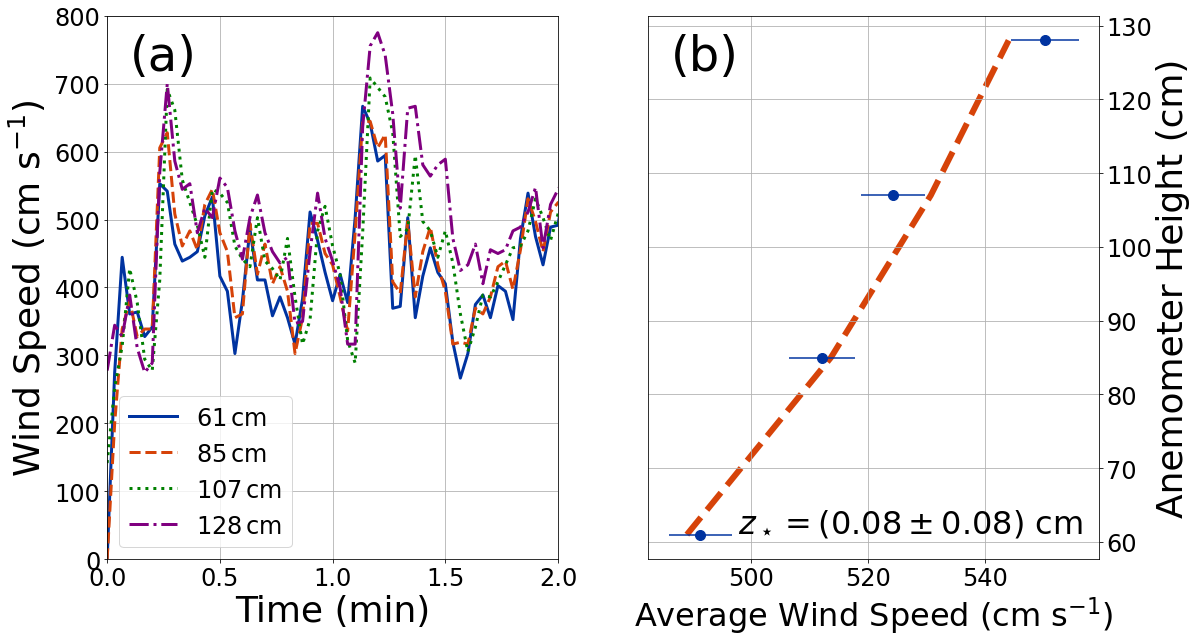

In [29]:
fig = plt.figure(figsize=(10*aspect_ratio, 10))
ax1 = fig.add_subplot(121)

heights = {"48": 61, "49": 85, "50": 107, "51": 128}
# heights = {"50": 107, "51": 128}
anemometer_names = heights.keys()

# Set my own colors
color = iter([BoiseState_blue, BoiseState_orange, 'green', 'purple'])
linestyles = iter(['-', '--', ':', '-.'])

# sampling is 0.5 Hz / once every two seconds for all of them
windspeeds = {}
means = {}
stds = {}

for key in heights.keys():
    c = next(color)
    linestyle = next(linestyles)
    
    ls = glob("WEATHER_*%s_May*" % key)
    
    data = np.genfromtxt(ls[0], skip_header=5, delimiter=',')

    # Convert from km/hr to cm/s
    windspeeds[key] = data[:,7]*27.7778
    means[key] = np.mean(data[:, 7]*27.7778)
    # error on the mean
    stds[key] = np.std(data[:, 7]*27.7778)/np.sqrt(len(data[:, 7]))
    
    # The data didn't record seconds for some reason.
    time = np.arange(0, 2.*(len(data[:, 7])), 2)
    ax1.plot(time/60, data[:, 7]*27.7778, lw=3, color=c, ls=linestyle, label=r'$%s\,{\rm cm}$' % heights[key])
#     ax1.scatter(time/60, data[:, 7]*27.7778, marker='.', label=r'$%s\,{\rm cm}$' % heights[key])

ax1.set_xlim([0, 2])
ax1.set_ylim([0, 800])
ax1.grid(True)
ax1.legend(loc='best', fontsize=24)
ax1.tick_params(labelsize=24)
ax1.set_xlabel("Time (min)", fontsize=36)
ax1.set_ylabel(r'Wind Speed (${\rm cm\ s^{-1}}$)', fontsize=36)
ax1.text(0.05, 0.90, "(a)", fontsize=48, transform=ax1.transAxes)

#### Estimating Roughness Scale ####

ax2 = fig.add_subplot(122)

x = np.array(list(heights.values()))
y = np.array(list(means.values()))
yerr = np.array(list(stds.values()))

# Law-of-the-Wall fit
log_z = np.log(x/np.min(x))
popt, pcov = curve_fit(lin_fit, log_z, y, sigma=yerr)
unc = np.sqrt(np.diag(pcov))
ustar = calc_ustar_from_slope(kappa, popt[0])
sigma_ustar = calc_sigma_ustar(kappa, unc[0])
zstar = calc_zstar_from_slope_and_intercept(np.min(x), popt[0], popt[1])
sigma_zstar = calc_sigma_zstar(popt[0], zstar, unc[0], popt[1], unc[1], np.abs(pcov[0,1]))

saved_zstar = zstar
saved_sigma_zstar = sigma_zstar

print(ustar, zstar)
print(sigma_ustar, sigma_zstar)

ax2.errorbar(y, x, xerr=yerr, ls='', marker='o', markersize=10, color=BoiseState_blue)
ax2.plot(np.polyval(popt, log_z), x, lw=6, color=BoiseState_orange, ls='--', zorder=-1)
ax2.text(0.05, 0.90, "(b)", fontsize=48, transform=ax2.transAxes)
ax2.text(0.2, 0.05, r'$z_\star = \left( %.2f\pm%.2f \right)\ {\rm cm}$' % (zstar, sigma_zstar), 
         fontsize=32, transform=ax2.transAxes)

ax2.grid(True)
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax2.tick_params(labelsize=24)
ax2.set_ylabel("Anemometer Height (cm)", fontsize=36)
ax2.set_xlabel(r'Average Wind Speed (${\rm cm\ s^{-1}}$)', fontsize=32)

# plt.savefig("../../Alamosa_Parking_Lot_Windspeeds.jpg", dpi=300, bbox_inches="tight")

In [70]:
x = np.array(list(heights.values()))
y = np.array(list(means.values()))
yerr = np.array(list(stds.values()))

wind_profile_popt, wind_profile_pcov = curve_fit(wind_profile, x, y, sigma=yerr, p0=[50., 0.1])
wind_profile_unc = np.sqrt(np.diag(wind_profile_pcov))
print(wind_profile_unc)

# Can I correctly propagate uncertainties?
sigma_ustar = calc_sigma_ustar(0.4, unc[0])
sigma_zstar = calc_sigma_zstar(popt[0], zstar, unc[0], popt[1], unc[1], pcov[0,1])
print(sigma_ustar, sigma_zstar)

[4.69558929 0.09281762]
4.69558853237308 0.09281781204465656


[153.76512171 368.07361724]
[39.35265132 20.80704837]
61.506048682141085 4.69132544252098
15.741060527159206 3.4453492628038775


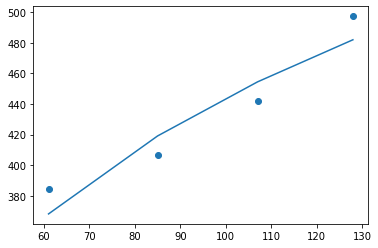

In [23]:
def sample_wind_profile(sample_time, t0, time=time, windspeeds=windspeeds):
    """
    Return wind speeds from four height sampled over the given sample time
    
    Args:
        sample_time (float): time over which to average in seconds
        t0 (float, optional): time at which at start averages
        time (float array, optional): measured times
        windspeeds (dict of float arrays, optional): wind speed time-series referenced by anemometer name
    
    Returns:
        Wind speeds averaged for sample time from different anemometer times series, one after another
    """
    
    # Run through each height, assuming the first one in windspeeds is the lowest and on up
    cur_t0 = t0
    
    averaged_heights = np.array([])
    averaged_windspeeds = np.array([])
    std_windspeeds = np.array([])
    for key in windspeeds.keys():
        ind = (time - cur_t0) <= sample_time
        
        averaged_windspeeds = np.append(np.mean(windspeeds[key][ind]), averaged_windspeeds)
        averaged_heights = np.append(heights[key], averaged_heights)
        std_windspeeds = np.append(np.std(windspeeds[key][ind])/(np.sqrt(len(windspeeds[key][ind])) - 1.),
                                   std_windspeeds)
        
        cur_t0 += sample_time
        
    return averaged_heights, averaged_windspeeds, std_windspeeds
    
averaged_heights, averaged_windspeeds, std_windspeeds = sample_wind_profile(150., 150.)
plt.scatter(averaged_heights, averaged_windspeeds)

x = np.log(averaged_heights/np.min(averaged_heights))
y = averaged_windspeeds
popt, pcov = curve_fit(lin_fit, x, y, sigma=std_windspeeds)
unc = np.sqrt(np.diag(pcov))

print(popt)
print(unc)

zstar = calculate_zstar_from_profile(averaged_heights, averaged_windspeeds)
ustar = calc_ustar_from_slope(0.4, popt[0])
sigma_ustar = calc_sigma_ustar(0.4, unc[0])
sigma_zstar = calc_sigma_zstar(popt[0], zstar, unc[0], popt[1], unc[1], pcov[1,0])
print(ustar, zstar)
print(sigma_ustar, sigma_zstar)

plt.plot(averaged_heights, lin_fit(x, *popt))

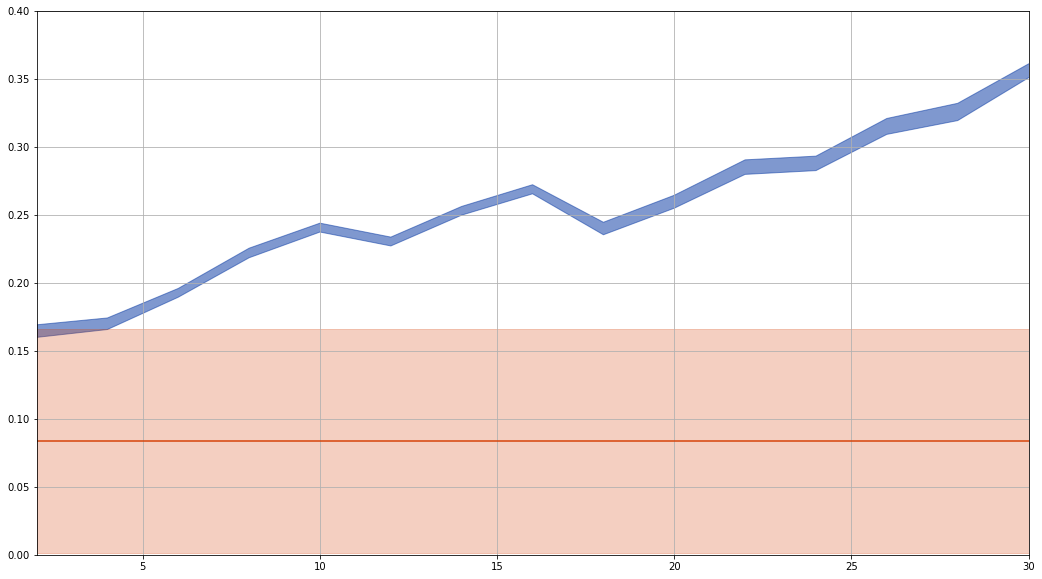

In [85]:
fig = plt.figure(figsize=(10*16/9, 10))
ax = fig.add_subplot(111)
# sample_times = 2.**(np.linspace(1, 8, 8))
sample_times = np.arange(2, 52, 2)
# sample_times = np.array([1000])
# print(sample_times)
num_tries = 1000

# saved_sample_times = np.array([])
# zstars = np.array([])
# zstars_sigma = np.array([])
# lower_sigmas = np.array([])
# upper_sigmas = np.array([])

# for i in range(len(sample_times)):
#     cur_saved_sample_times = np.array([])
#     cur_zstars = np.array([])
    
#     for j in range(num_tries):
        
#         # Make sure there is plenty of time at the end
#         t0 = choice(time[time < time[-1] - len(heights)*sample_times[i]])
# #         t0 = 0.
#         averaged_heights, averaged_windspeeds, std_windspeeds = sample_wind_profile(sample_times[i], t0)
    
#         x = np.log(averaged_heights/np.min(averaged_heights))
#         y = averaged_windspeeds
#         popt, pcov = curve_fit(lin_fit, x, y, sigma=std_windspeeds)
#         unc = np.sqrt(np.diag(pcov))
                
#         zstar = calc_zstar_from_slope_and_intercept(np.min(averaged_heights), *popt)

#         cur_zstars = np.append(zstar, cur_zstars)
#         cur_saved_sample_times = np.append(sample_times[i], cur_saved_sample_times)
        
#     zstars = np.append(np.quantile(cur_zstars, [0.5]), zstars)
#     lower_sigma, upper_sigma = np.quantile(cur_zstars, [0.16, 0.84]) - np.quantile(cur_zstars, [0.5])
#     lower_sigmas = np.append(-lower_sigma, lower_sigmas)
#     upper_sigmas = np.append(upper_sigma, upper_sigmas)
    
# #     zstars_sigma = np.append(np.std(cur_zstars), zstars_sigma)
#     saved_sample_times = np.append(sample_times[i], saved_sample_times)


#     zstars = np.append(cur_zstars, zstars)
#     zstars_sigma = np.append(np.std(cur_zstars), zstars_sigma)
#     saved_sample_times = np.append(sample_times[i]*np.ones_like(cur_zstars), saved_sample_times)

# ax.errorbar(saved_sample_times, zstars, np.vstack([lower_sigmas, upper_sigmas]), marker='o', color=BoiseState_blue)
# ax.scatter(saved_sample_times, (zstars - saved_zstar)/zstars_sigma)
# ax.scatter(saved_sample_times, zstars, marker='o', color=BoiseState_blue, s=100)

# ax.plot(saved_sample_times, zstars, color=BoiseState_blue, lw=3)
ax.fill_between(saved_sample_times, zstars - lower_sigmas/np.sqrt(num_tries), 
                zstars - upper_sigmas/np.sqrt(num_tries), color=BoiseState_blue, alpha=0.5)

# print(saved_sample_times)
# print(zstars)
ax.axhline(saved_zstar, color=BoiseState_orange)
ax.fill_between(saved_sample_times, saved_zstar + saved_sigma_zstar, saved_zstar - saved_sigma_zstar, 
                color=BoiseState_orange, alpha=0.25)

ax.set_ylim([0, 0.4])
ax.set_xlim([2, 30])
ax.grid(True)

50.205000196761546
58.92751627777773
0.1682524263213198


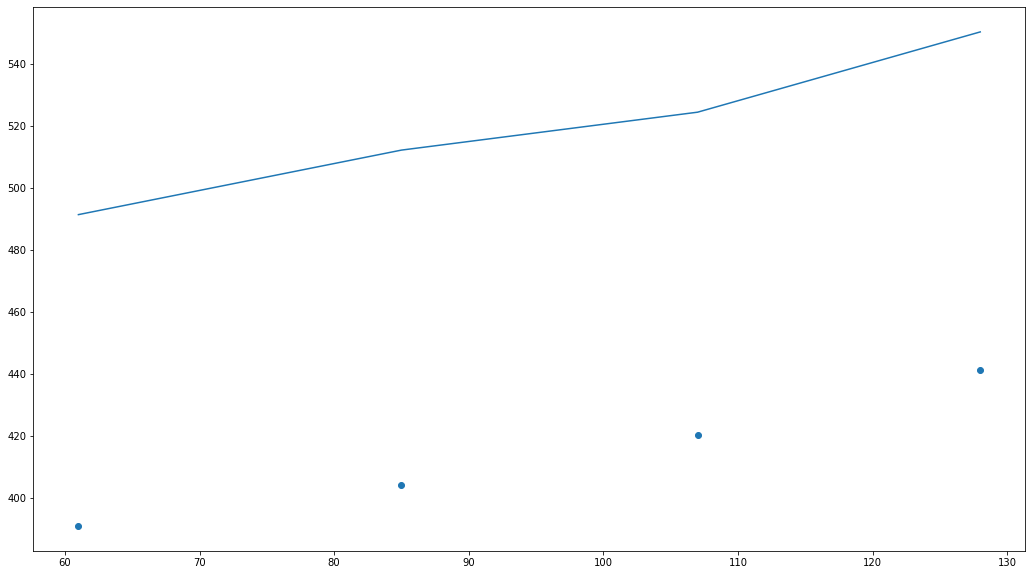

In [336]:
fig = plt.figure(figsize=(10*16/9, 10))
ax = fig.add_subplot(111)
sample_times = [5.]
# print(sample_times)
num_tries = 1

saved_sample_times = np.array([])
zstars = np.array([])

for i in range(len(sample_times)):
    for j in range(num_tries):
        
        # Make sure there is plenty of time at the end
        t0 = 470.
        averaged_heights, averaged_windspeeds, std_windspeeds = sample_wind_profile(sample_times[i], t0)
        
        plt.scatter(averaged_heights, averaged_windspeeds)
        plt.plot(saved_averaged_heights, saved_averaged_windspeeds)
        
        print(np.max(averaged_windspeeds) - np.min(averaged_windspeeds))
        print(np.max(saved_averaged_windspeeds) - np.min(saved_averaged_windspeeds))
        
        print(calculate_zstar_from_profile(averaged_heights, averaged_windspeeds))

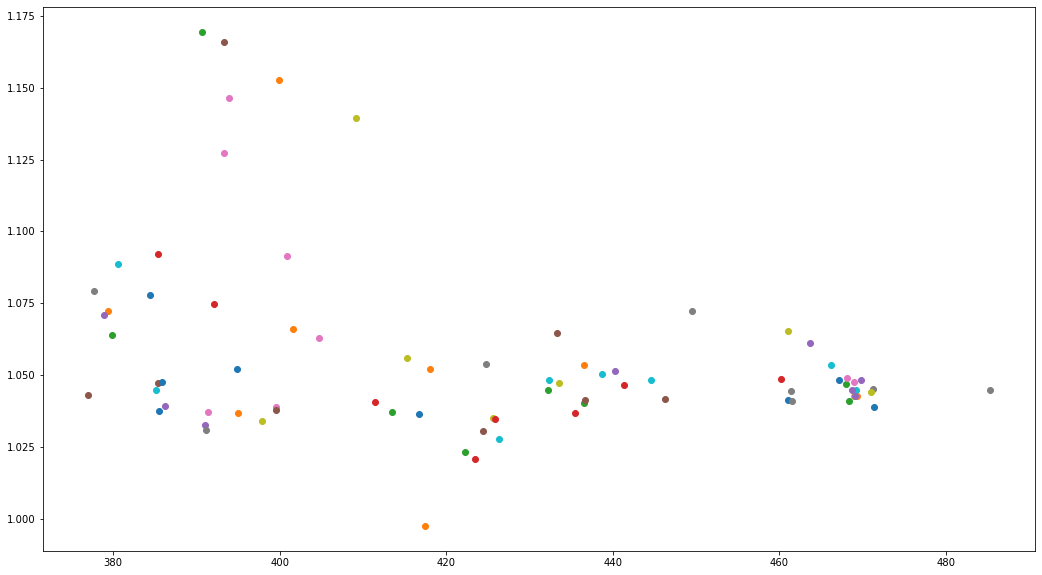

In [300]:
fig = plt.figure(figsize=(10*16/9, 10))
ax = fig.add_subplot(111)
sample_times = 2.**(np.linspace(1, 8, 8))
num_tries = 10

saved_sample_times = np.array([])
zstars = np.array([])

for i in range(len(sample_times)):
    for j in range(num_tries):
        
        # Make sure there is plenty of time at the end
        t0 = choice(time[time < time[-1] - len(heights)*sample_times[i]])
        averaged_heights, averaged_windspeeds, std_windspeeds = sample_wind_profile(sample_times[i], t0)
        
        plt.plot(averaged_windspeeds[-1], averaged_windspeeds[2]/averaged_windspeeds[-1],
                 ls='', marker='o')